In [41]:
from imports import *

In [42]:
query = "select * from cleaned_application_ml"
app_data = sql_connect(query)
app_data.head()

Connection to SQL Server established successfully.
Connection closed.


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AVERAGE_EXTERNAL_RATING,TOT_PREV_APP,PREV_APPROVED_CNT,PREV_CANCELLED_CNT,PREV_REFUSED_CNT,PREV_UNUSED_CNT,ISMISSING_BUREAU_INFO
0,100002,1,Cash loans,M,0,1,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120.0,-1,1,1,0,1,1,0,Laborers,1,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,2,2,2,2,-1134,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.1618,0,0,0,0,0,0
1,100003,0,Cash loans,F,0,0,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291.0,-1,1,1,0,1,1,0,Core staff,2,1,1,MONDAY,11,0,0,0,0,0,0,School,1,0,1,0,-828,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.4668,0,0,0,0,0,0
2,100004,0,Revolving loans,M,1,1,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531.0,26,1,1,1,1,1,0,Laborers,1,2,2,MONDAY,9,0,0,0,0,0,0,Government,0,0,0,0,-815,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.6427,0,0,0,0,0,0
3,100006,0,Cash loans,F,0,1,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437.0,-1,1,1,0,1,0,0,Laborers,2,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,2,0,2,0,-617,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.6504,0,0,0,0,0,1
4,100007,0,Cash loans,M,0,1,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458.0,-1,1,1,0,1,0,0,Core staff,1,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0,0,0,0,-1106,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.3227,1,1,0,0,0,0


In [43]:
numeric_col = [col for col in app_data.columns if app_data[col].dtype != 'object' and app_data[col].nunique() > 2 and col not in ['SK_ID_CURR', 'TARGET']]

### Class imbalance is there

Text(0.5, 0, 'Target')

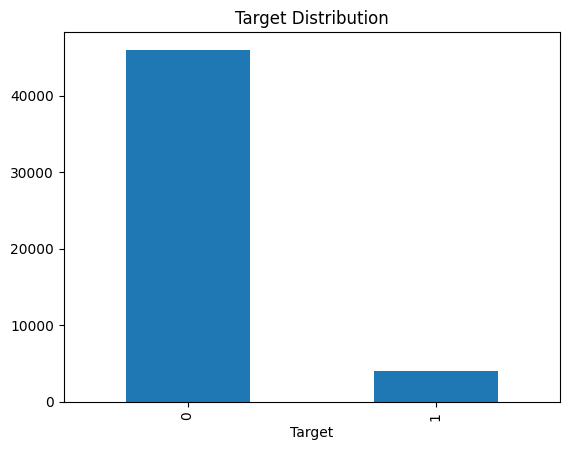

In [44]:
app_data['TARGET'].value_counts().plot(kind='bar', title='Target Distribution')
plt.xlabel('Target')    

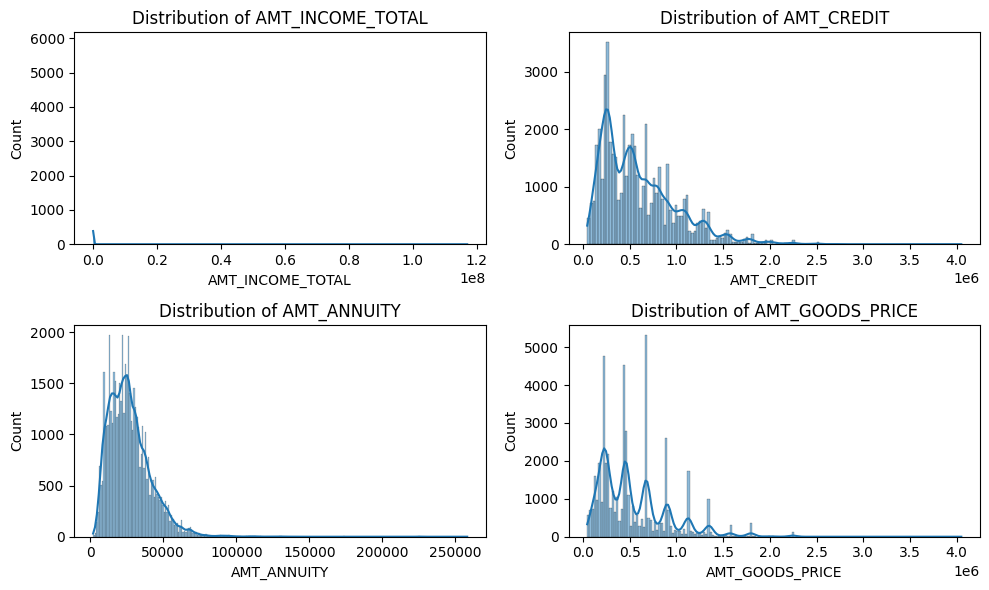

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
for i, col in enumerate(numeric_col[1:5]):
    sns.histplot(app_data[col], kde=True, ax=ax[i])
    ax[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show();

All the amount-related features are highly skewed. To preserve the data and mitigate the effect of outliers, a log transformation will be applied. This will help in reducing skewness and improving the distribution for further analysis.

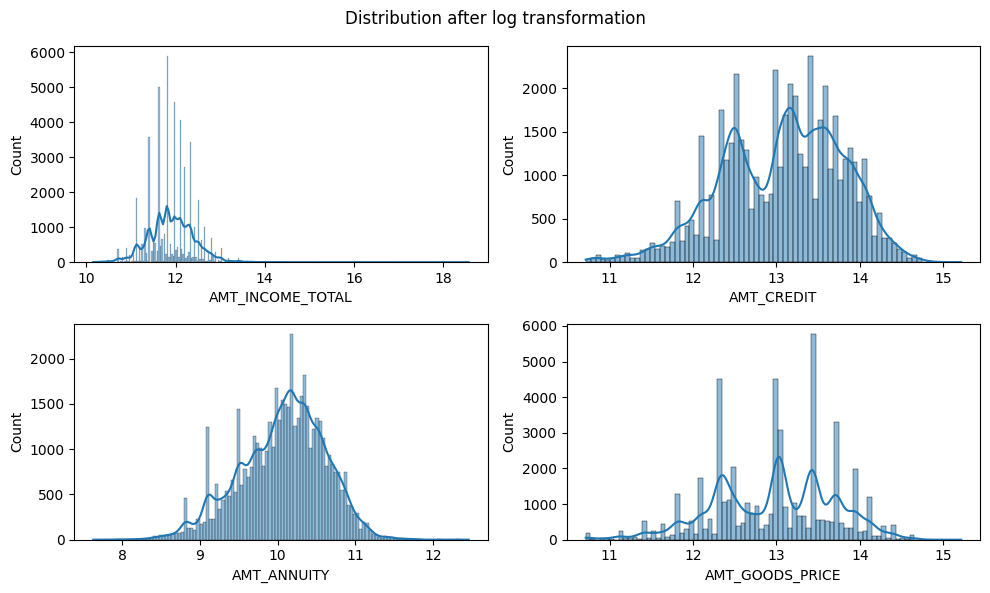

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
for i, col in enumerate(numeric_col[1:5]):
    sns.histplot(np.log1p(app_data[col]), kde=True, ax=ax[i])
plt.suptitle(f'Distribution after log transformation')
plt.tight_layout()
plt.show();

The log transformation has worked well, bringing all values within a reasonable range. However, there remains one influential point in AMT_INCOME_TOTAL that warrants further investigation. It may be an outlier or a data entry error and will be reviewed accordingly.

In [47]:
app_data[app_data['AMT_INCOME_TOTAL'] == app_data['AMT_INCOME_TOTAL'].max()]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AVERAGE_EXTERNAL_RATING,TOT_PREV_APP,PREV_APPROVED_CNT,PREV_CANCELLED_CNT,PREV_REFUSED_CNT,PREV_UNUSED_CNT,ISMISSING_BUREAU_INFO
12840,114967,1,Cash loans,F,0,1,1,117000000.0,562491.0,26194.5,454500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010643,-12615,-922,-6762.0,-3643.0,-1,1,1,0,1,0,0,Laborers,3,2,2,TUESDAY,14,0,0,0,0,0,0,Business Entity Type 3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.2398,0,0,0,0,0,0


A Laborer with such an unusually high income is highly unlikely, suggesting a possible data entry error. Therefore, this record is considered an outlier and will be removed, as it does not represent a valid or informative data point.

In [48]:
app_data.drop(12840, inplace=True)

In [49]:
for col in numeric_col[1:5]:
    app_data[col] = np.log1p(app_data[col])



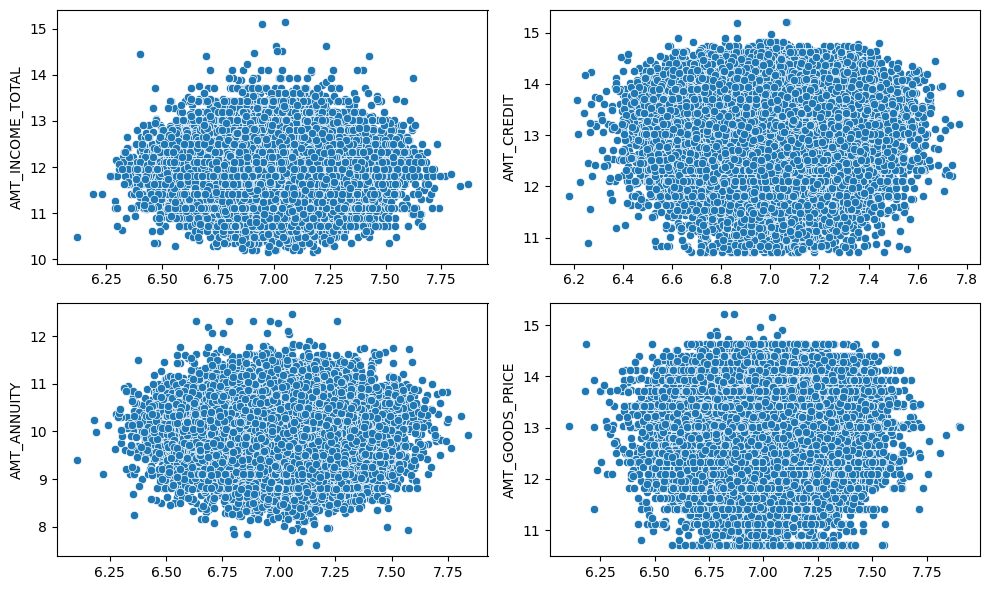

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
for i, col in enumerate(numeric_col[1:5]):
   
    sns.scatterplot(x=np.random.normal(7, 0.2, size=len(app_data)), y=app_data[col], ax=ax[i])
plt.tight_layout()
plt.show()

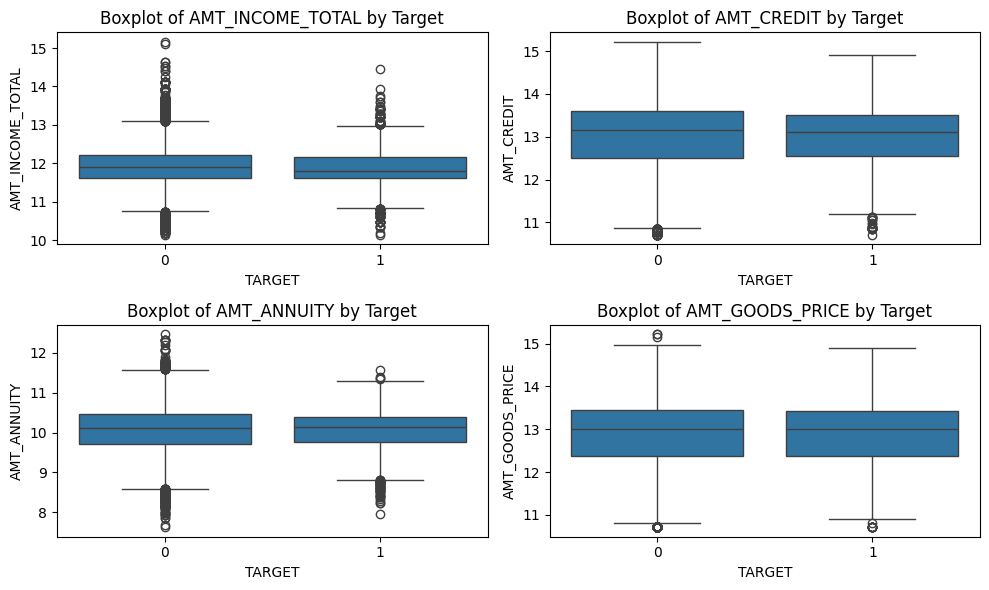

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
for i, col in enumerate(numeric_col[1:5]):
    #column = col  + '_LOG'
    sns.boxplot(x = 'TARGET', y = col, ax=ax[i], data=app_data)
    ax[i].set_title(f'Boxplot of {col} by Target')
plt.tight_layout()
plt.show();

It does not appear that repayment difficulties are strongly dependent on the most important individual columns. Since the dataset contains a large number of features, visualizing each one would be impractical. Therefore, dimensionality reduction is necessary to uncover meaningful patterns.

We will proceed with Principal Component Analysis (PCA), but before that, we need to standardize the data to ensure all features contribute equally to the analysis.


In [52]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


X = app_data.drop(columns=['SK_ID_CURR', 'TARGET'])
y = app_data['TARGET']

numeric_cols = [col for col in X.columns if X[col].dtype != 'object' and X[col].nunique() > 2]
binary_cols = [col for col in X.columns if X[col].dtype != 'object' and X[col].nunique() == 2]
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('bin', 'passthrough', binary_cols)
    ]
)

X_transformed = preprocessor.fit_transform(X)



In [53]:
from sklearn.decomposition import  PCA

pca_model = PCA()

pca_x = pca_model.fit_transform(X_transformed)


In [54]:
cum_var = np.cumsum(pca_model.explained_variance_ratio_)
print(f'{len(cum_var[cum_var < 0.95])} components explain 95% of the variance')

46 components explain 95% of the variance


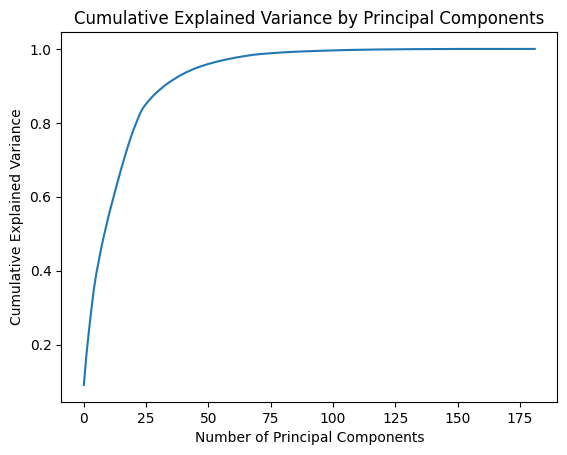

In [55]:
plt.plot(cum_var)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components');

The first four principal components explain approximately 30% of the total variance. While this provides some insight, it is not sufficient to fully capture the structure of the data. Since plotting all 46 components is not practical, we will limit our visual analysis to the first four principal components.

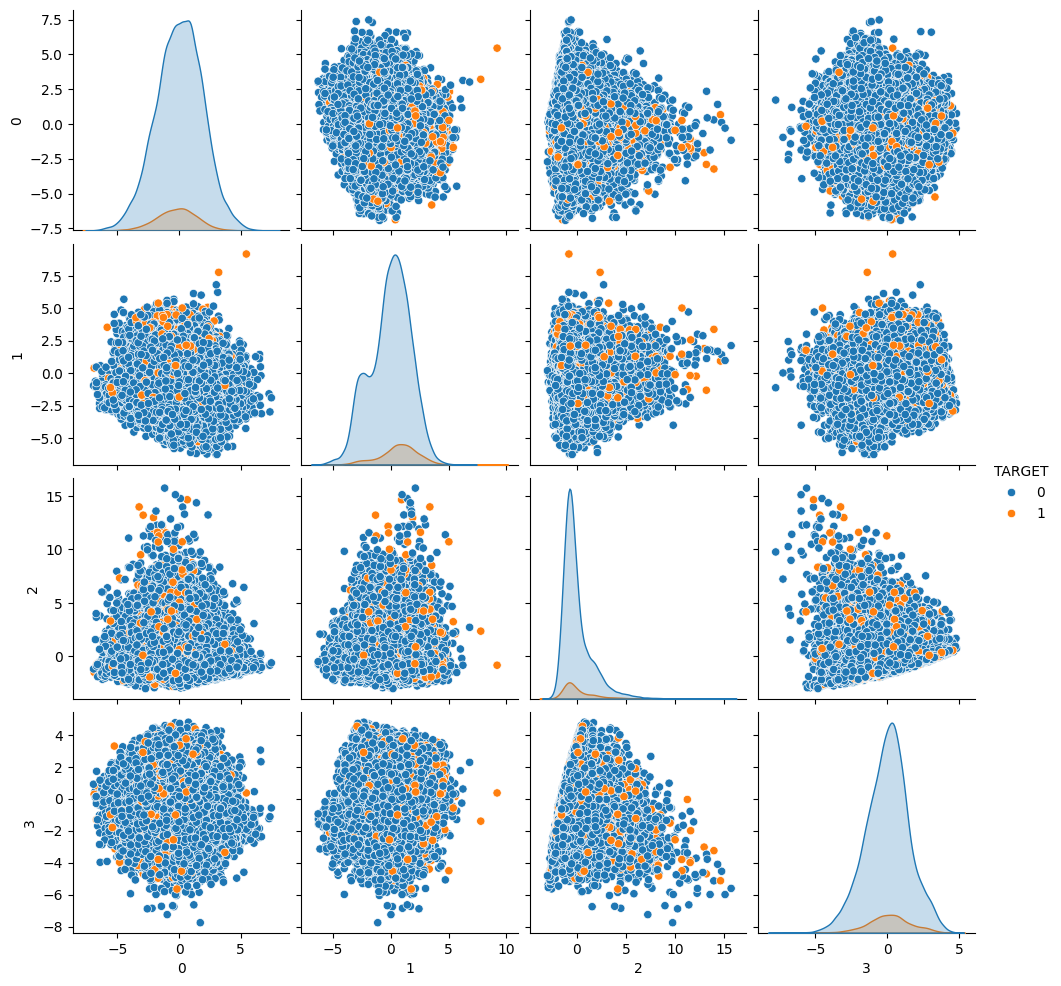

In [56]:
pca_df = pd.DataFrame(pca_x[:, :4]) 
pca_df['TARGET'] = y.values  


sns.pairplot(pca_df, hue='TARGET')

### No clear seperation

The dataset contains a high number of features (181 columns), many of which are numeric, categorical, or binary. While realtions were explored, meaningful patterns between the features and the target variable (TARGET) were not visually obvious.

Even after applying dimensionality reduction techniques like PCA (Principal Component Analysis) and visualizing the first few principal components, there was no clear separation between classes. This is expected in high-dimensional tabular data, where complex patterns may not be easily captured or visualized in 2D.

Therefore, further exploration via traditional EDA is unlikely to yield actionable insights. We now proceed to modelling, where machine learning algorithms can leverage the full feature space to uncover predictive patterns.